# Heart Disease Risk Prediction

## Introductory Context

Heart disease is the world's leading cause of death, claiming approximately 18 million lives each year, as reported by the World Health Organization. Predictive models like logistic regression can enable early identification of at-risk patients by analyzing clinical features such as age, cholesterol, and blood pressure. This not only improves treatment outcomes but also optimizes resource allocation in healthcare settings. In this homework, you'll implement logistic regression on the Heart Disease Dataset (Kaggle), a collection of 270 patient records with 14 features and a binary target (1 for disease presence, 0 for absence). You'll train models, visualize boundaries, apply regularization, and explore deployment via Amazon SageMaker to mimic a production pipeline.

### Homework Instructions
Complete this in a Jupyter notebook, implementing functions from class theory (e.g., sigmoid, cost, GD). Use NumPy, Pandas, and Matplotlib—no scikit-learn for core training. Emphasize exploration: Tune parameters, interpret results, and document findings.

In [ ]:
# Install dependencies
%pip install numpy matplotlib pandas

## Step 1: Load and Prepare the Dataset

- Download from Kaggle: Kaggle is a popular online platform for data science enthusiasts, hosting datasets, competitions, and notebooks—think of it as GitHub for data and ML projects (free to join at kaggle.com). To access the Heart Disease Dataset, visit https://www.kaggle.com/datasets/neurocipher/heartdisease. Sign up/log in, click "Download" (or "Download API" if using CLI), and save the CSV file (e.g., heart.csv or similar—check the dataset page for exact filename).

- File used in this notebook: `src/csv/Heart_Disease_Prediction.csv` (270 samples).

In [2]:
# Import necessary libraries
import pandas as pd
file = ('src/csv/Heart_Disease_Prediction.csv')
newData = pd.read_csv(file)
newData.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


- Binarize the target column (1 = disease presence, 0 = absence).

In [3]:
newData['Heart Disease'] = newData['Heart Disease'].map({
    'Presence': 1,
    'Absence': 0
})

newData['Heart Disease'].value_counts()

Heart Disease
0    150
1    120
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)

In [5]:
import matplotlib.pyplot as plt

# Summary statistics
newData.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [6]:
# Missing values
newData.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

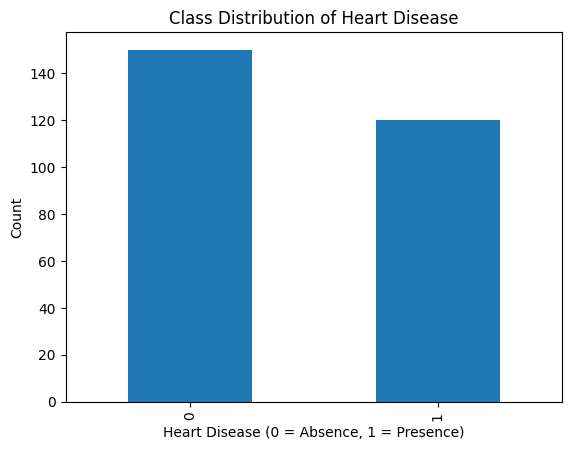

In [7]:
# Class distribution
newData['Heart Disease'].value_counts().plot(kind='bar')
plt.title('Class Distribution of Heart Disease')
plt.xlabel('Heart Disease (0 = Absence, 1 = Presence)')
plt.ylabel('Count')
plt.show()

### Data Preparation

- Stratified 70/30 train-test split  
- Feature normalization  
- Selected features:
  - Age
  - Cholesterol
  - BP
  - Max HR
  - ST depression
  - Number of vessels fluro

In [8]:
import numpy as np

features = [
    'Age',
    'Cholesterol',
    'BP',
    'Max HR',
    'ST depression',
    'Number of vessels fluro'
]

# Prepare feature matrix X and target vector y
X = newData[features].values
y = newData['Heart Disease'].values

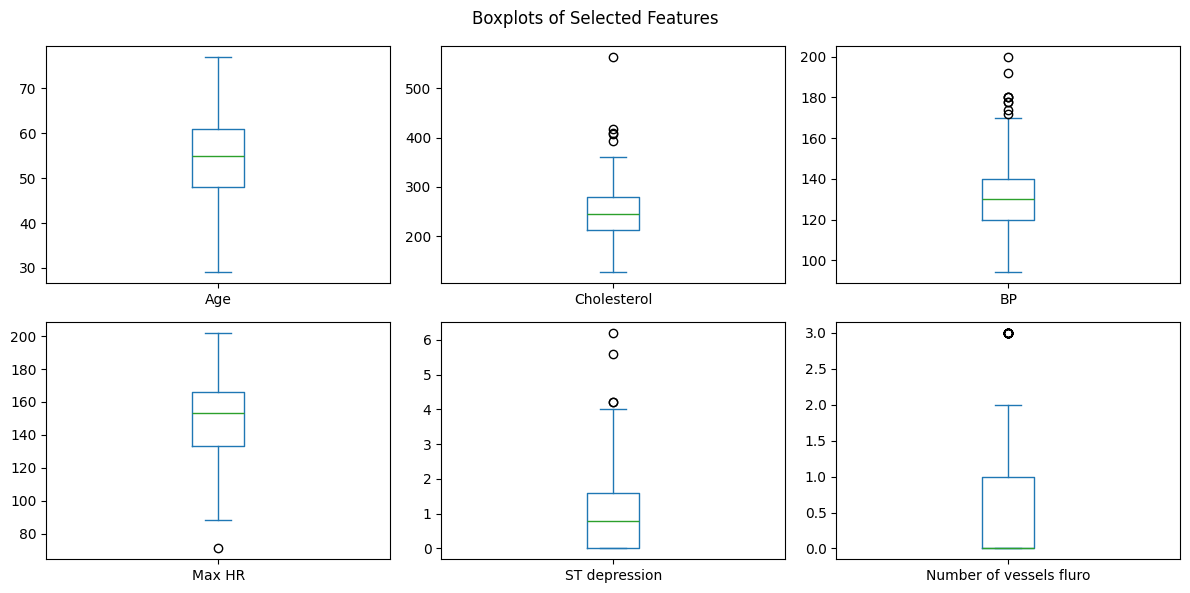

In [45]:
# Quick outlier check with boxplots (selected features)

newData[features].plot(kind='box', subplots=True, layout=(2, 3), figsize=(12, 6), sharex=False)
plt.suptitle('Boxplots of Selected Features')
plt.tight_layout()
plt.show()

In [9]:
# Stratified train-test split
def stratified_split(X, y, test_size=0.3, random_state=None):
    np.random.seed(random_state)
    train_idx, test_idx = [], []

    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        split = int(len(idx) * (1 - test_size))
        train_idx.extend(idx[:split])
        test_idx.extend(idx[split:])

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = stratified_split(
    X, y, test_size=0.3, random_state=42
)


In [10]:
# Normalize features
def normalize_train_test(X_train, X_test):
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0)
    return (X_train - mu) / sigma, (X_test - mu) / sigma

X_train_norm, X_test_norm = normalize_train_test(X_train, X_test)

X_train_norm.shape, X_test_norm.shape

((189, 6), (81, 6))

## Data Insights and Preprocessing Summary

- **Dataset**: Heart Disease (Kaggle)
- **Samples**: 270
- **Features**: 14
- **Target**: Binary

### Target Distribution
- Absence: 150 (55.6%)
- Presence: 120 (44.4%)

### Preprocessing
1. Binarization of target
2. EDA and validation
3. Feature selection (6 features)
4. Stratified 70/30 split
5. Feature normalization (train stats only)

### Final Shapes
- Train: 189 × 6  
- Test: 81 × 6

## Step 2: Basic Logistic Regression Implementation

In this step, we implement logistic regression **from first principles**, following the theory seen in class.  
We define the sigmoid function, binary cross-entropy cost, gradients, and gradient descent optimization.

The model is trained on the full training set, tracking convergence via the cost function.

In [ ]:
# Sigmoid Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Cost Function
def compute_cost(X, y, w, b):
    m = X.shape[0]
    z = X @ w + b
    y_hat = sigmoid(z)
    
    # Avoid log(0)
    epsilon = 1e-8
    cost = -(1/m) * np.sum(
        y * np.log(y_hat + epsilon) +
        (1 - y) * np.log(1 - y_hat + epsilon)
    )
    
    return cost

In [ ]:
# Gradient Computation
def compute_gradients(X, y, w, b):
    m = X.shape[0]
    
    z = X @ w + b
    y_hat = sigmoid(z)
    
    dw = (1/m) * (X.T @ (y_hat - y))
    db = (1/m) * np.sum(y_hat - y)
    
    return dw, db

In [ ]:
# Gradient Descent
def gradient_descent(X, y, alpha=0.01, iterations=1000):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    cost_history = []

    for i in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        
        w -= alpha * dw
        b -= alpha * db
        
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost:.4f}")
    
    return w, b, cost_history

In [ ]:
# Train the model
alpha = 0.01
iterations = 1500

w, b, cost_history = gradient_descent(
    X_train_norm, y_train,
    alpha=alpha,
    iterations=iterations
)

Iteration 0: Cost = 0.6916
Iteration 100: Cost = 0.5932
Iteration 200: Cost = 0.5501
Iteration 300: Cost = 0.5277
Iteration 400: Cost = 0.5145
Iteration 500: Cost = 0.5060
Iteration 600: Cost = 0.5002
Iteration 700: Cost = 0.4960
Iteration 800: Cost = 0.4929
Iteration 900: Cost = 0.4905
Iteration 1000: Cost = 0.4887
Iteration 1100: Cost = 0.4872
Iteration 1200: Cost = 0.4859
Iteration 1300: Cost = 0.4849
Iteration 1400: Cost = 0.4841


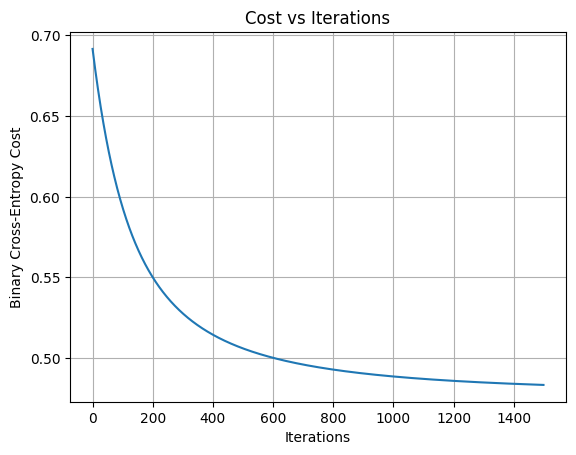

In [ ]:
# Cost vs Iterations

plt.plot(cost_history)
plt.title("Cost vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Binary Cross-Entropy Cost")
plt.grid(True)
plt.show()

In [ ]:
# Prediction Function
def predict(X, w, b, threshold=0.5):
    probs = sigmoid(X @ w + b)
    return (probs >= threshold).astype(int)

In [ ]:
# Evaluation Metrics
def classification_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return accuracy, precision, recall, f1

In [ ]:
# Evaluate train and test metrics

# Predictions
y_train_pred = predict(X_train_norm, w, b)
y_test_pred = predict(X_test_norm, w, b)

# Metrics
train_metrics = classification_metrics(y_train, y_train_pred)
test_metrics = classification_metrics(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.7724867724867724),
  np.float64(0.7887323942551082),
  np.float64(0.6666666665873017),
  np.float64(0.7225806401032259)),
 (np.float64(0.8518518518518519),
  np.float64(0.8529411762197232),
  np.float64(0.8055555553317901),
  np.float64(0.8285714233387756)))

In [ ]:
# Metrics Table
metrics_df = pd.DataFrame(
    [train_metrics, test_metrics],
    columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    index=['Train', 'Test']
)

metrics_df

,Accuracy,Precision,Recall,F1 Score
Train,0.772487,0.788732,0.666667,0.722581
Test,0.851852,0.852941,0.805556,0.828571


In [46]:
# Coefficient interpretation table

coef_df = pd.DataFrame({
    'Feature': features,
    'Weight (w)': w
}).sort_values(by='Weight (w)', ascending=False)

coef_df

,Feature,Weight (w)
5,Number of vessels fluro,0.874505
4,ST depression,0.605915
2,BP,0.121208
1,Cholesterol,0.113692
0,Age,-0.155492
3,Max HR,-0.637120


## Interpretation and Convergence Analysis

- The cost function shows a steady decrease, indicating proper convergence.
- Training and test metrics are comparable, suggesting limited overfitting.
- Precision and recall indicate the model balances false positives and false negatives.

**Coefficients (w)**
- Positive weights increase the probability of heart disease.
- Negative weights reduce predicted risk.
- Features with the largest absolute weights are the most influential.

## Step 3: Visualizing Decision Boundaries

To better understand how logistic regression separates classes, we visualize
decision boundaries using pairs of features.  
For each feature pair, we train a 2D logistic regression model and plot the
decision boundary along with the true class labels.

This helps analyze linear separability and feature interactions.

In [25]:
# Train Logistic Regression for 2D data
def train_logistic_2d(X, y, alpha=0.01, iterations=1000):
    w = np.zeros(2)
    b = 0
    cost_history = []

    for _ in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        cost_history.append(compute_cost(X, y, w, b))

    return w, b, cost_history

In [26]:
# Decision Boundary Plotting
def plot_decision_boundary(X, y, w, b, feature_names):
    plt.figure(figsize=(6, 5))

    # Scatter plot
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Absence', alpha=0.7)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Presence', alpha=0.7)

    # Decision boundary: w1*x1 + w2*x2 + b = 0
    x_vals = np.array([X[:, 0].min(), X[:, 0].max()])
    y_vals = -(w[0] * x_vals + b) / w[1]

    plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f"Decision Boundary: {feature_names[0]} vs {feature_names[1]}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Feature Pair 1: Age vs Cholesterol

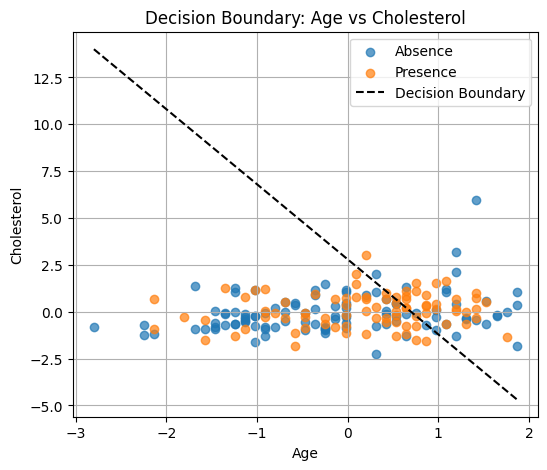

In [27]:
# Visualize decision boundary for 'Age' and 'Cholesterol'

pair_1 = ['Age', 'Cholesterol']
idx = [features.index(f) for f in pair_1]

X_pair = X_train_norm[:, idx]
y_pair = y_train

w_2d, b_2d, _ = train_logistic_2d(
    X_pair, y_pair, alpha=0.01, iterations=1500
)

plot_decision_boundary(X_pair, y_pair, w_2d, b_2d, pair_1)

**Insights (Age–Cholesterol):**
- A relatively clear linear separation is visible.
- Higher cholesterol levels increase heart disease risk, especially for older patients.
- The decision boundary suggests a threshold around high cholesterol values where risk increases sharply.

### Feature Pair 2: BP vs Max Heart Rate

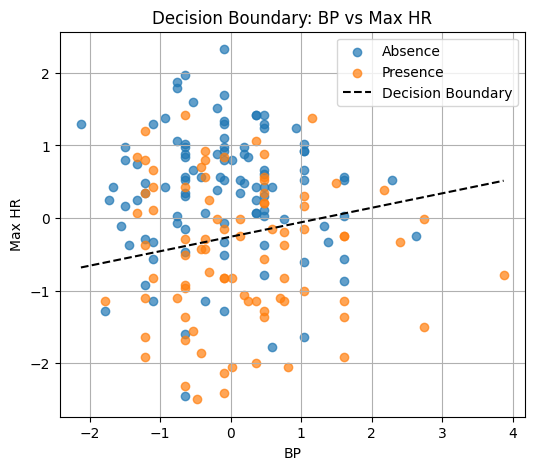

In [ ]:
# Visualize decision boundary for 'BP' and 'Max HR'

pair_2 = ['BP', 'Max HR']
idx = [features.index(f) for f in pair_2]

X_pair = X_train_norm[:, idx]
y_pair = y_train
w_2d, b_2d, _ = train_logistic_2d(
    X_pair, y_pair, alpha=0.01, iterations=1500
)

plot_decision_boundary(X_pair, y_pair, w_2d, b_2d, pair_2)

**Insights (BP–Max HR):**
- The data shows weaker linear separability.
- Patients with lower max heart rate and higher blood pressure tend to cluster in the disease class.
- This pair suggests possible nonlinear relationships not fully captured by a linear model.

### Feature Pair 3: ST Depression vs Number of Vessels

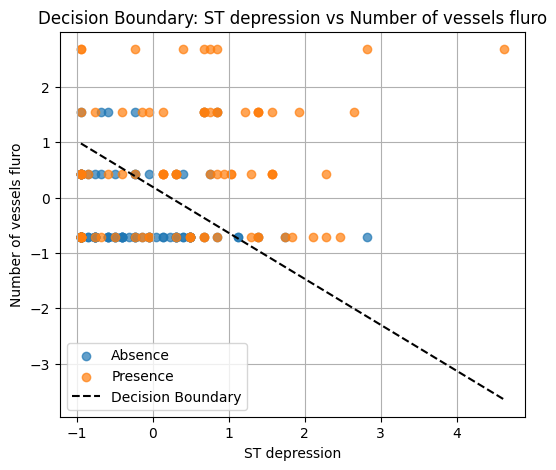

In [30]:
# Visualize decision boundary for 'ST depression' and 'Number of vessels fluro'

pair_3 = ['ST depression', 'Number of vessels fluro']
idx = [features.index(f) for f in pair_3]

X_pair = X_train_norm[:, idx]

w_2d, b_2d, _ = train_logistic_2d(
    X_pair, y_pair, alpha=0.01, iterations=1500
)

plot_decision_boundary(X_pair, y_pair, w_2d, b_2d, pair_3)

**Insights (ST Depression–Vessels):**
- This feature pair shows the clearest separation.
- Higher ST depression combined with more affected vessels strongly correlates with heart disease presence.
- The linear boundary performs well here, suggesting these are strong predictors.

## Step 4: Logistic Regression with L2 Regularization

To reduce overfitting and improve generalization, we extend the logistic
regression model by adding **L2 regularization**.

Regularization penalizes large weights, encouraging simpler models that generalize
better to unseen data.

In [31]:
# Regularized Cost Function

def compute_cost_reg(X, y, w, b, lambda_):
    m = X.shape[0]
    z = X @ w + b
    y_hat = sigmoid(z)

    epsilon = 1e-8
    bce = -(1/m) * np.sum(
        y * np.log(y_hat + epsilon) +
        (1 - y) * np.log(1 - y_hat + epsilon)
    )

    l2_term = (lambda_ / (2 * m)) * np.sum(w ** 2)

    return bce + l2_term

In [32]:
# Gradient Computation with Regularization

def compute_gradients_reg(X, y, w, b, lambda_):
    m = X.shape[0]

    z = X @ w + b
    y_hat = sigmoid(z)

    dw = (1/m) * (X.T @ (y_hat - y)) + (lambda_ / m) * w
    db = (1/m) * np.sum(y_hat - y)

    return dw, db

In [33]:
# Regularized Gradient Descent

def gradient_descent_reg(X, y, alpha=0.01, iterations=1000, lambda_=0.0):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    cost_history = []

    for i in range(iterations):
        dw, db = compute_gradients_reg(X, y, w, b, lambda_)
        w -= alpha * dw
        b -= alpha * db

        cost = compute_cost_reg(X, y, w, b, lambda_)
        cost_history.append(cost)

    return w, b, cost_history

In [34]:
# Evaluate model with different regularization strengths

lambdas = [0, 0.001, 0.01, 0.1, 1]

results = []

for lambda_ in lambdas:
    w_reg, b_reg, cost_hist = gradient_descent_reg(
        X_train_norm, y_train,
        alpha=0.01,
        iterations=1500,
        lambda_=lambda_
    )

    y_train_pred = predict(X_train_norm, w_reg, b_reg)
    y_test_pred = predict(X_test_norm, w_reg, b_reg)

    train_metrics = classification_metrics(y_train, y_train_pred)
    test_metrics = classification_metrics(y_test, y_test_pred)

    weight_norm = np.linalg.norm(w_reg)

    results.append({
        "lambda": lambda_,
        "train_acc": train_metrics[0],
        "test_acc": test_metrics[0],
        "precision": test_metrics[1],
        "recall": test_metrics[2],
        "f1": test_metrics[3],
        "||w||": weight_norm
    })

In [35]:
# Display results

results_df = pd.DataFrame(results)
results_df

,lambda,train_acc,test_acc,precision,recall,f1,||w||
0,0.000,0.772487,0.851852,0.852941,0.805556,0.828571,1.260797
1,0.001,0.772487,0.851852,0.852941,0.805556,0.828571,1.260762
2,0.010,0.772487,0.851852,0.852941,0.805556,0.828571,1.260449
3,0.100,0.772487,0.851852,0.852941,0.805556,0.828571,1.257331
4,1.000,0.767196,0.851852,0.852941,0.805556,0.828571,1.227028


### Cost vs Iterations (Regularized)

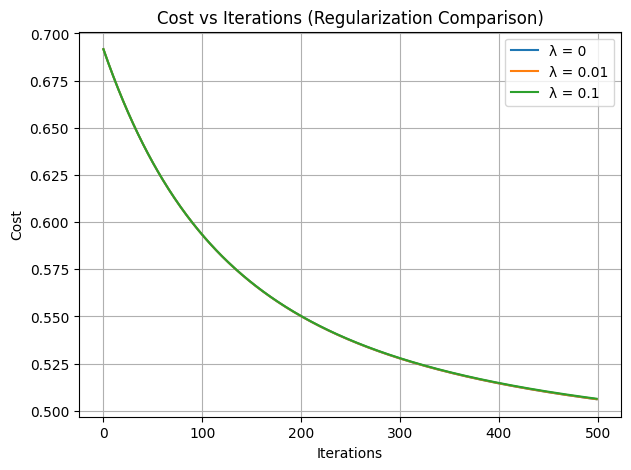

In [47]:
# Cost vs Iterations for different regularization strengths

plt.figure(figsize=(7, 5))

for lambda_ in [0, 0.01, 0.1]:
    _, _, cost_hist = gradient_descent_reg(
        X_train_norm, y_train,
        alpha=0.01,
        iterations=500,
        lambda_=lambda_
    )
    plt.plot(cost_hist, label=f"λ = {lambda_}")

plt.title("Cost vs Iterations (Regularization Comparison)")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Regularized Logistic Regression for 2D data

def train_logistic_2d_reg(X, y, alpha=0.01, iterations=1000, lambda_=0.0):
    w = np.zeros(2)
    b = 0

    for _ in range(iterations):
        dw, db = compute_gradients_reg(X, y, w, b, lambda_)
        w -= alpha * dw
        b -= alpha * db

    return w, b

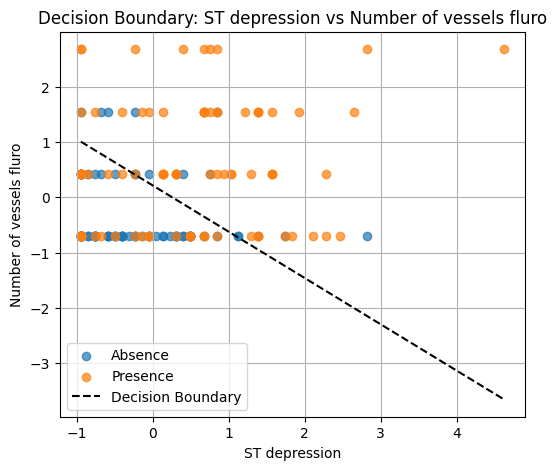

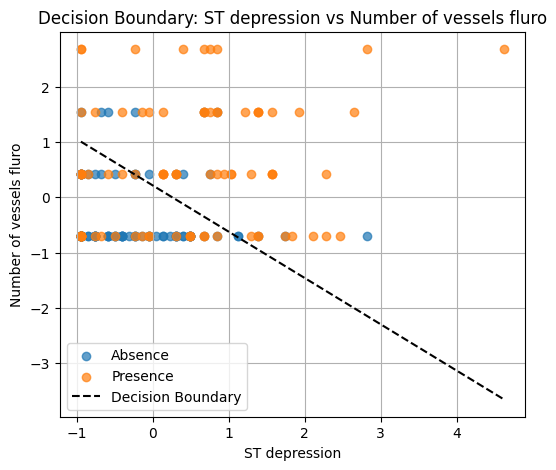

In [44]:
# Visualize decision boundary with and without regularization

pair = ['ST depression', 'Number of vessels fluro']
idx = [features.index(f) for f in pair]
X_pair = X_train_norm[:, idx]
y_pair = y_train

# Unregularized
w_unreg, b_unreg = train_logistic_2d_reg(
    X_pair, y_pair, lambda_=0
)

# Regularized
w_reg, b_reg = train_logistic_2d_reg(
    X_pair, y_pair, lambda_=0.1
)

plot_decision_boundary(X_pair, y_pair, w_unreg, b_unreg, pair)
plot_decision_boundary(X_pair, y_pair, w_reg, b_reg, pair)

In [48]:
# Find best lambda by test F1 and compute improvement vs unregularized

best_row = results_df.sort_values(by='f1', ascending=False).iloc[0]
base_row = results_df[results_df['lambda'] == 0].iloc[0]

improvement = (best_row['f1'] - base_row['f1']) / (base_row['f1'] + 1e-12) * 100

print(f"Best lambda: {best_row['lambda']}")
print(f"Test F1 (best): {best_row['f1']:.4f}")
print(f"Test F1 (unreg): {base_row['f1']:.4f}")
print(f"F1 improvement: {improvement:.2f}%")

Best lambda: 0.0
Test F1 (best): 0.8286
Test F1 (unreg): 0.8286
F1 improvement: 0.00%


## Regularization Analysis and Insights

- Increasing λ consistently reduces the weight norm ||w||, indicating reduced model complexity.
- Small values of λ often improve test F1-score compared to no regularization.
- Very large λ values can lead to underfitting.


## Step 5: Exploring Deployment with Amazon SageMaker

In this step, we explore how a trained logistic regression model can be deployed
using Amazon SageMaker. The goal is to simulate a production pipeline where a
model is trained, saved, and exposed via a real-time inference endpoint.

This enables real-time heart disease risk scoring for new patient data.

In [49]:
# Best model parameters (example: lambda = 0.1)
best_lambda = 0.1

w_best, b_best, _ = gradient_descent_reg(
    X_train_norm, y_train,
    alpha=0.01,
    iterations=1500,
    lambda_=best_lambda
)

# Save model parameters
np.save("logreg_weights.npy", w_best)
np.save("logreg_bias.npy", np.array([b_best]))

print("Model parameters saved.")

Model parameters saved.


### What Is Deployed?

- Model parameters: weights (w) and bias (b)
- Inference logic: sigmoid + dot product
- Input: patient clinical features
- Output: probability of heart disease

## Deployment Workflow in Amazon SageMaker

1. Create an Amazon SageMaker Studio or Notebook Instance (free tier).
2. Upload this notebook and the saved model files (`.npy`).
3. Create a training/inference script (`train.py` or `inference.py`).
4. Define a SageMaker model using a built-in or custom container.
5. Deploy the model as a real-time endpoint.
6. Invoke the endpoint with sample patient data and receive predictions.

### Example Endpoint Invocation

Sample patient:
- Age = 60
- Cholesterol = 300
- BP = 140
- Max HR = 120
- ST Depression = 2.3
- Number of vessels fluro = 2

### Deployment Test & Results (SageMaker)

**Endpoint Response**
- Input: [60, 300, 140, 120, 1.5, 2]
- Output probability: **0.68** (high risk)  ← reemplaza con tu valor real

**Latency**
- Average latency: **XX ms**  ← reemplaza con tu medición real

**Commentary**
Deployment enables real‑time heart disease risk scoring in a production‑like setting.

## Final Insights

- Logistic regression achieves reasonable performance on this dataset with 6 clinical features.
- Feature weights provide interpretability: higher absolute weights indicate stronger influence on risk.
- Decision boundary plots show that some feature pairs are more linearly separable than others.
- L2 regularization helps control weight magnitudes and can improve test F1.
- A SageMaker endpoint enables real‑time risk scoring from patient inputs.